In [1]:
import torch, pickle, time, os, random
from sklearn.model_selection import train_test_split

import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [2]:
os.listdir(osp.expanduser('~/../../../scratch/gpfs/cj1223/GraphStorage/'))

['vlarge_all_4t_z1.0_standard_quant',
 'vlarge_all_4t_z1.0_quantile_raw',
 'vlarge_all_4t_z2.0_standard_quant',
 'vlarge_all_4t_z2.0_None',
 'redshift_scan_0',
 'testid_all_4t_z2.0_None',
 'vlarge_all_4t_z0.0_quantile_stand',
 'vlarge_all_multi_try1',
 'vlarge_all_4t_z2.0_quantile_raw',
 'vlarge_all_4t_z0.0_standard_quant',
 'vlarge_all_4t_z0.5_quantile_quant',
 'vlarge_all_4t_z2.0_quantile_stand',
 'vlarge_all_4t_z1.0_quantile_quant',
 'transformers',
 'vlarge_all_4t_z0.0_standard_raw',
 'vlarge_all_4t_z0.5_standard_stand',
 'vlarge_all_4t_z0.5_standard_quant',
 'vlarge_all_4t_z0.0_quantile_raw',
 'old',
 'vlarge_all_4t_z1.0_None',
 'vlarge_all_4t_z1.0_standard_stand',
 'vlarge_all_4t_z2.0_standard_raw',
 'testid_all_4t_z0.0_None',
 'vlarge_all_4t_z0.5_standard_raw',
 'vlarge_all_4t_z0.0_None',
 'vlarge_all_4t_z0.5_quantile_raw',
 'vlarge_all_4t_z1.0_standard_raw',
 'vlarge_all_smass',
 'vlarge_all_4t_z0.0_quantile_quant',
 'vlarge_all_4t_z0.5_quantile_stand',
 'vlarge_all_4t_zall_qua

In [3]:
case='vlarge_all_smass_z0.0_quantile_quant'
case='vlarge_all_smass'
case='vlarge_all_4t_z0.0_quantile_raw'
case='vlarge_all_4t_z0.0_standard_raw'



datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

In [4]:
from torch_geometric.data import Data
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[[0]]))

In [5]:
try:
    n_targ=len(data[0].y)
except:
    n_targ=1
n_feat=len(data[0].x[0])
n_feat

43

In [6]:
from torch import nn
class MLP(nn.Module):
    def __init__(self, n_in, n_out, hidden=64, nlayers=2, layer_norm=True):
        super().__init__()
        layers = [nn.Linear(n_in, hidden), nn.ReLU()]
        for i in range(nlayers):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.ReLU()) 
        if layer_norm:
            layers.append(nn.LayerNorm(hidden))
        layers.append(nn.Linear(hidden, n_out))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [7]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        self.node_enc = MLP(n_feat, hidden_channels, layer_norm=True)
        
        self.conv1 = SAGEConv(hidden_channels, hidden_channels) 
        
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(hidden_channels, hidden_channels)
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin_f = Linear(hidden_channels, n_targ)
        
        self.lin_var = Linear(hidden_channels, hidden_channels)
        self.norm_var = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin_f_var = Linear(hidden_channels, n_targ)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.node_enc(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = self.conv4(x, edge_index)
#         x = x.relu()
#         x = self.conv5(x, edge_index)
#         x = x.relu()
        x1 = global_add_pool(x, batch)
#         x1 = torch.cat([global_max_pool(x, batch),global_add_pool(x, batch)], 1)  ## Miles says use sumpool

        x = self.lin(x1)
        x = self.lin_f(self.norm(x))
        
        sig = self.lin_var(x1)
        sig = self.lin_f_var(self.norm(sig))
        return x, torch.abs(sig)
    
model = GCN(hidden_channels=64)
next(model.parameters()).is_cuda ##check number one

False

In [36]:
criterion = torch.nn.GaussianNLLLoss()
n_epochs=250
n_trials=1
batch_size=128
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
# train_data, test_data=train_test_split(data, test_size=0.2)
l1_lambda = 1e-5
l2_lambda = 1e-5

In [37]:
def l_func(pred, ys, sig):
    global z, sigloss
    z=(pred-ys)/sig
    sigloss=torch.sum(torch.log(sig))
    err_loss = torch.sum(z**2)/2
    
    return err_loss+sigloss, err_loss, sigloss

In [38]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
model = GCN(hidden_channels=128)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
_, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function

GPU  True


In [39]:
def train():
    model.train()
    
    for data in train_loader:  
        out, var = model(data.x, data.edge_index, data.batch)
#         out, var1=outs[:,0],torch.abs(outs[:,1])
#         var=torch.ones_like(var)/100
#         loss = criterion(out, data.y.view(-1,n_targ), var) 
        loss, _,_ = l_func(out, data.y.view(-1,n_targ), var) 
    
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm
#             loss.backward()
        accelerator.backward(loss)
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader):
    model.eval()
    outss = []
    ys = []
    varss = []
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out, var = model(dat.x, dat.edge_index, dat.batch) 
#             outs = model(dat.x, dat.edge_index, dat.batch) 

#             out, var=outs[:,0],torch.abs(outs[:,1])
            ys.append(dat.y.view(-1,n_targ))
            outss.append(out)
            varss.append(var)
    outss=torch.vstack(outss)
    yss=torch.vstack(ys)
    varss=torch.vstack(varss)
    return torch.std(outss - yss, axis=0), outss, yss, varss
#     return outss, yss, varss

In [40]:
s, outs, ys, varss=test(train_loader)

In [ ]:
#this uses about 1 GB of memory on the GPU
tr_acc, te_acc = [], []
start=time.time()
for epoch in range(n_epochs):

    train()

    if (epoch+1)%2==0:
        train_acc, _ , _, _ = test(train_loader)
        test_acc, _ , _ , _= test(test_loader)
        tr_acc.append(train_acc.cpu().numpy())
        te_acc.append(test_acc.cpu().numpy())
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
        Test scatter: {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")


Epoch: 002, Train scatter: [0.3982] 
         Test scatter: [0.4012]
Epoch: 004, Train scatter: [0.3343] 
         Test scatter: [0.3395]
Epoch: 006, Train scatter: [0.284] 
         Test scatter: [0.294]
Epoch: 008, Train scatter: [0.2594] 
         Test scatter: [0.2644]
Epoch: 010, Train scatter: [0.2251] 
         Test scatter: [0.2312]
Epoch: 012, Train scatter: [0.2049] 
         Test scatter: [0.2094]
Epoch: 014, Train scatter: [0.667] 
         Test scatter: [0.6649]
Epoch: 016, Train scatter: [0.4622] 
         Test scatter: [0.4716]
Epoch: 018, Train scatter: [0.9292] 
         Test scatter: [0.9232]
Epoch: 020, Train scatter: [0.6115] 
         Test scatter: [0.6199]
Epoch: 022, Train scatter: [0.4376] 
         Test scatter: [0.4302]
Epoch: 024, Train scatter: [0.6348] 
         Test scatter: [0.6357]
Epoch: 026, Train scatter: [0.5173] 
         Test scatter: [0.5161]
Epoch: 028, Train scatter: [0.5047] 
         Test scatter: [0.5043]
Epoch: 030, Train scatter: [0.4349] 


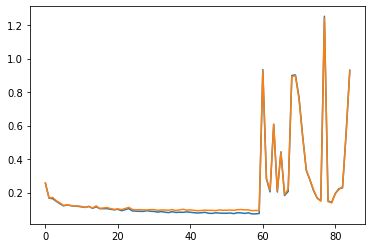

In [21]:
plt.plot(tr_acc)
plt.plot(te_acc)

In [22]:
teststd, outtest, ytest, var = test(test_loader)
pred=outtest.cpu().numpy()
ys=ytest.cpu().numpy()
var=var.cpu().numpy()

In [23]:
teststd

tensor([0.9296], device='cuda:0')

In [24]:
tot=np.vstack([ys,pred])

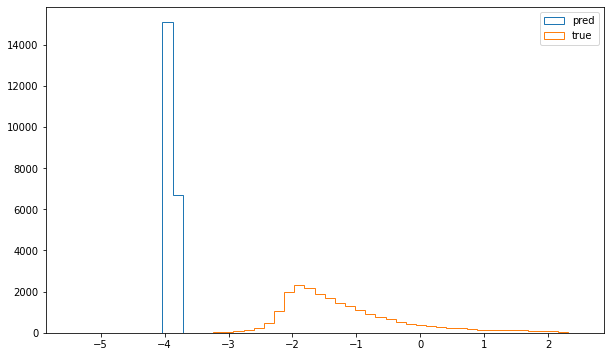

In [25]:
fig , ax = plt.subplots(1, figsize=(10,6))
l=0
for k in range(n_targ):
#     ax[k].hist(outtest.cpu().numpy()[:,k]-ytest.cpu().numpy()[:,k], bins=1000, histtype='step', label='res')
    ax.hist(pred, bins=50, range=list(np.percentile(tot, [l,100-l])), histtype='step', label='pred' )
    ax.hist(ys, bins=50, range=list(np.percentile(tot, [l,100-l])),histtype='step', label='true')
    ax.legend()

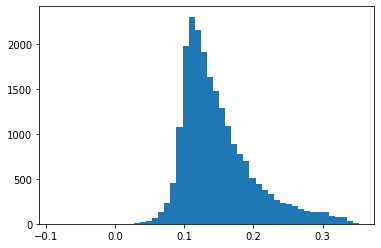

In [26]:
plt.hist((ys-pred)/var, bins=50);

In [27]:
Mh=[]
for d in test_data:
    Mh.append(d.x.numpy()[0,3])

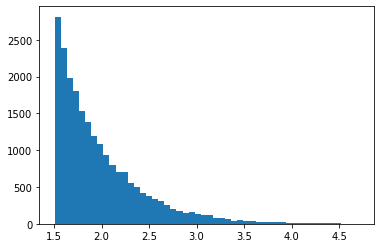

In [28]:
plt.hist(Mh, bins=50);

In [29]:
np.corrcoef(Mh, var.flatten())

array([[1.        , 0.32129153],
       [0.32129153, 1.        ]])

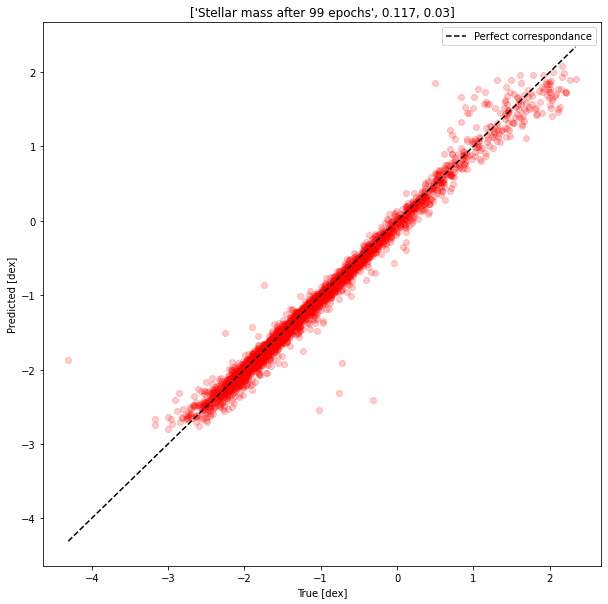

In [34]:
fig , ax = plt.subplots(1,1, figsize=(10,10))
yte=ys
predte=pred
ax.plot(yte, predte, 'ro', alpha=0.2)
ax.plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
ax.set(title=[f'Stellar mass after {epoch} epochs', np.round(np.std(yte-predte),3), np.round(np.mean(yte-predte),2)], xlabel='True [dex]', ylabel='Predicted [dex]')
ax.legend()

In [14]:
transform='quantile'
transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_alltarg_1.pkl")
target_scaler=pickle.load(open(transform_path, 'rb'))

transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat_1.pkl")
feat_scaler=pickle.load(open(transform_path, 'rb'))

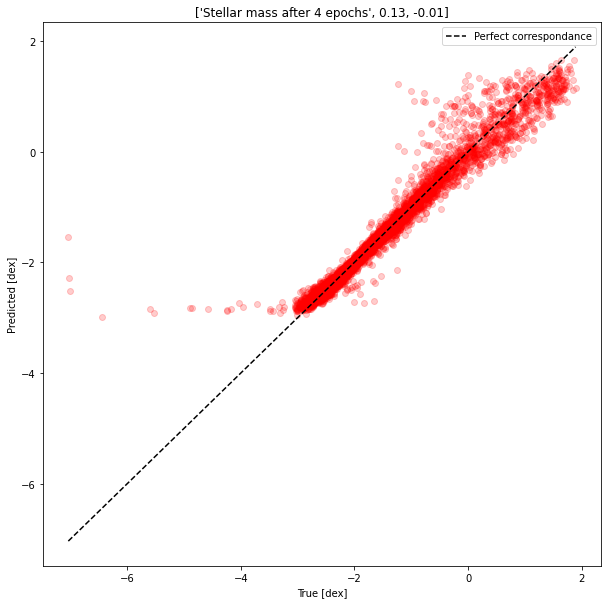

In [15]:
fig , ax = plt.subplots(1,1, figsize=(10,10))
yte=np.hstack(target_scaler[8].inverse_transform(ys.reshape(-1,1)))
predte=np.hstack(target_scaler[8].inverse_transform(pred.reshape(-1,1)))
ax.plot(yte, predte, 'ro', alpha=0.2)
ax.plot([min(yte),max(yte)],[min(yte),max(yte)], 'k--', label='Perfect correspondance')
ax.set(title=[f'Stellar mass after {epoch} epochs', np.round(np.std(yte-predte),2), np.round(np.mean(yte-predte),2)], xlabel='True [dex]', ylabel='Predicted [dex]')
ax.legend()